#Install Libraries

In [2]:
!pip install timm==0.9
!pip install tensorboardX==2.6.2.2
!pip install fastervit
!pip install torch torchvision torchaudio
!pip install datasets matplotlib pandas pillow timm torcheval torchtnt==0.2.0 tqdm
!pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [3]:
# PyTorch Setup
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("CPU is being used")

GPU is available


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries

In [42]:
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
import urllib.request
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import timm
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF
from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy
from tqdm.auto import tqdm
from fastervit import create_model
import os
import torch
import torchvision
from torch import nn
import collections
tqdm.pandas()

#Create Model

In [6]:
model = timm.create_model('faster_vit_0_224', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 361M/361M [00:05<00:00, 64.5MB/s]


In [25]:
model = model.to(device)

#Prepare the Dataset

In [56]:
from pathlib import Path

# Assuming dataset_path is a string containing the path to your Google Drive folder
dataset_path = '/content/drive/MyDrive/Bone Break Classification/Train'

# Convert the string path to a Path object
dataset_path = Path(dataset_path)

# Now you can use the Path object to iterate over its contents
img_folder_paths = [folder for folder in dataset_path.iterdir() if folder.is_dir()]

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})

,Image Folder
0,Spiral Fracture
1,Pathological Fracture
2,Oblique Fracture
3,Longitudinal Fracture
4,Impacted Fracture
5,Hairline Fracture
6,Greenstick Fracture
7,Fracture Dislocation
8,Comminuted Fracture
9,Avulsion Fracture


In [57]:
# Get a list of all image file paths from the image folders
class_file_paths = [get_img_files(folder) for folder in img_folder_paths]

# Get all image files in the 'img_dir' directory
img_paths = [
    file
    for folder in class_file_paths # Iterate through each image folder
    for file in folder # Get a list of image files in each image folder
]

# Print the number of image files
print(f"Number of Images: {len(img_paths)}")

# Display the first five entries using a Pandas DataFrame
pd.DataFrame(img_paths).head()

Number of Images: 989


,0
0,/content/drive/MyDrive/Bone Break Classification/Train/Spiral Fracture/A-Radiograph-shows-a-spiral-fracture-of-humeral-diaphyseal-segment-AO-cl-12A1-B-Good_png.rf.6ba5de62185d0377399671c1e6d1fb0d.jpg
1,/content/drive/MyDrive/Bone Break Classification/Train/Spiral Fracture/A-Plain-radiograph-shaft-and-multiple-scattered_Q640_jpg.rf.7d83c56445dd5e9a7334a7d49569fdda.jpg
2,/content/drive/MyDrive/Bone Break Classification/Train/Spiral Fracture/A-Plain-radiograph-spiral-in-left-femoral-shaft-and-multiple-scattered_Q640_jpg.rf.7d83c56445dd5e9a7334a7d49569fdda.jpg
3,/content/drive/MyDrive/Bone Break Classification/Train/Spiral Fracture/a-AP-X-ray-of-shaft-of-humerus-spiral-fracture-b-lateral-X-ray-of-humerus-shaft_Q640_jpg.rf.95098e2ff06610ceeb70463198071ea0.jpg
4,/content/drive/MyDrive/Bone Break Classification/Train/Spiral Fracture/3732968824_e910c1e03d_c_jpg.rf.4fbfb0cfb1a4323067fe589611d84981.jpg


In [59]:
# Get the number of samples for each image class
class_counts_dict = {folder[0].parent.name:len(folder) for folder in class_file_paths}

# Get a list of unique labels
class_names = list(class_counts_dict.keys())

# Display the labels and the corresponding number of samples using a Pandas DataFrame
class_counts = pd.DataFrame.from_dict({'Count':class_counts_dict})
class_counts

,Count
Avulsion Fracture,109
Comminuted Fracture,134
Fracture Dislocation,137
Greenstick Fracture,106
Hairline Fracture,101
Impacted Fracture,75
Longitudinal Fracture,68
Oblique Fracture,69
Pathological Fracture,116
Spiral Fracture,74


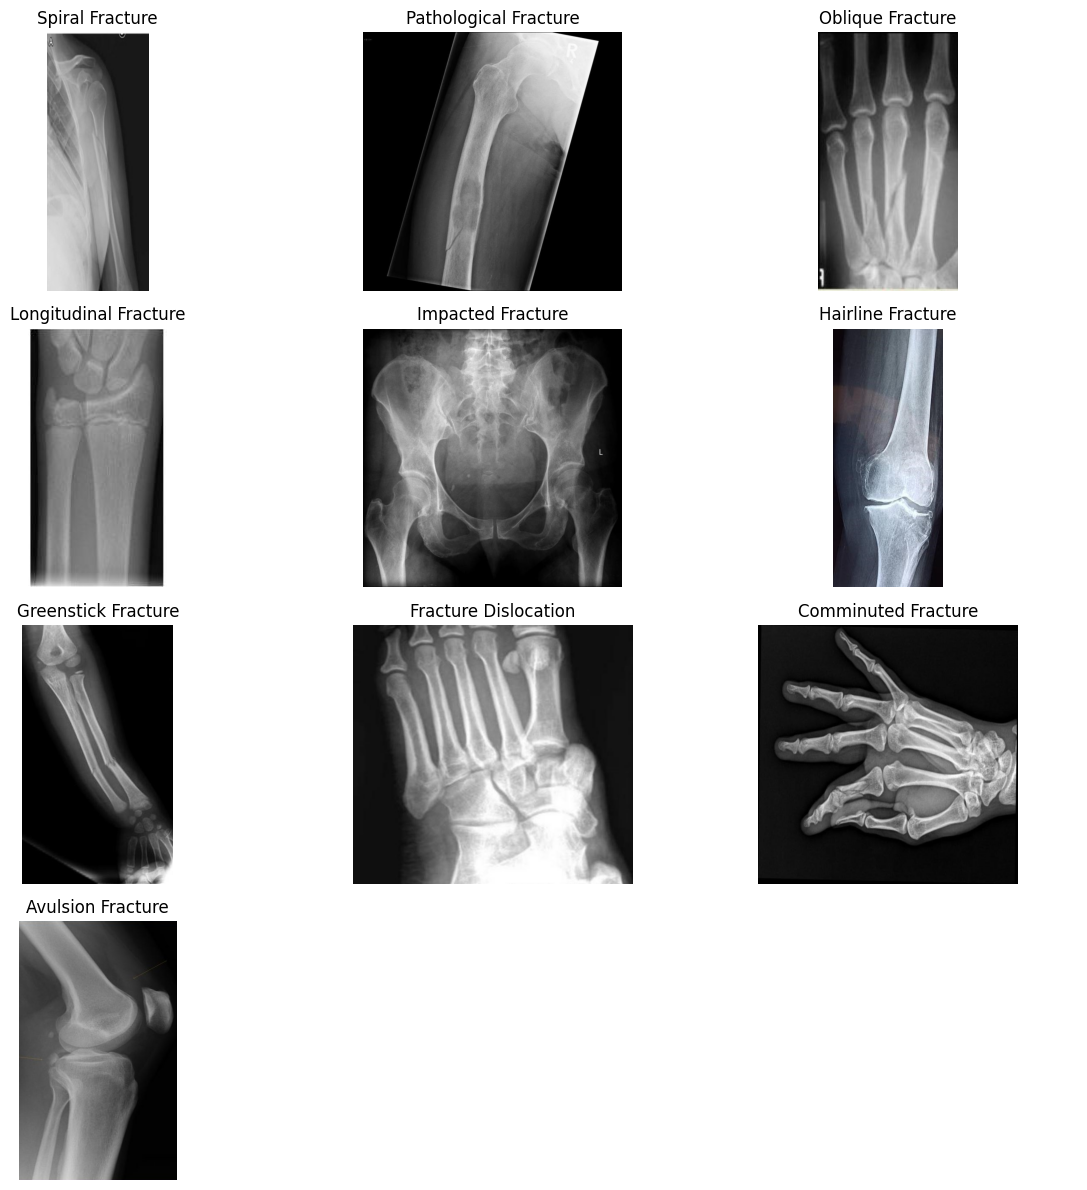

In [60]:
# Create a list to store the first image found for each class
sample_image_paths = [folder[0] for folder in class_file_paths]
sample_labels = [path.parent.stem for path in sample_image_paths]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_image_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_image_paths) else 0)
n_cols = grid_size

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(sample_image_paths) and sample_image_paths[i]:
        # Add the image to the subplot
        ax.imshow(np.array(Image.open(sample_image_paths[i])))
        # Set the title to the corresponding class name
        ax.set_title(sample_labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

In [61]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_paths),
    "Validation Samples:": len(val_paths)
}).to_frame().style.hide(axis='columns')

Training Samples:,791
Validation Samples:,198


In [72]:
data_dir = '/content/drive/MyDrive/Bone Break Classification'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'Train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'Test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

#Fine Tune the Model

In [39]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [76]:
def train_fine_tuning(net, learning_rate, num_epochs=20,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(train_loader)
    test_iter = torch.utils.data.DataLoader(test_loader)
    loss = nn.CrossEntropyLoss(reduction="none")
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-2)

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss_value = loss(outputs, labels)
            loss_value = loss_value.mean()  # Compute the mean loss across the batch
            loss_value.backward()
            optimizer.step()

            running_loss += loss_value.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        avg_loss = running_loss / len(train_loader)

        # Evaluate the model on the test set
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
train_fine_tuning(model, 5e-5)

Epoch 1/20, Train Loss: 6.4900, Train Accuracy: 0.0698, Test Accuracy: 0.1214
Epoch 2/20, Train Loss: 5.3476, Train Accuracy: 0.2063, Test Accuracy: 0.2214
Epoch 3/20, Train Loss: 4.1379, Train Accuracy: 0.3589, Test Accuracy: 0.3429
Epoch 4/20, Train Loss: 2.9583, Train Accuracy: 0.4894, Test Accuracy: 0.3286
Epoch 5/20, Train Loss: 2.2338, Train Accuracy: 0.5622, Test Accuracy: 0.3286
Epoch 6/20, Train Loss: 1.8341, Train Accuracy: 0.6097, Test Accuracy: 0.3286
Epoch 7/20, Train Loss: 1.3334, Train Accuracy: 0.6967, Test Accuracy: 0.3929
Epoch 8/20, Train Loss: 1.1557, Train Accuracy: 0.7139, Test Accuracy: 0.3929
Epoch 9/20, Train Loss: 0.9106, Train Accuracy: 0.7806, Test Accuracy: 0.3357
Epoch 10/20, Train Loss: 0.7634, Train Accuracy: 0.8008, Test Accuracy: 0.3500
Epoch 11/20, Train Loss: 0.6706, Train Accuracy: 0.8291, Test Accuracy: 0.4143
Epoch 12/20, Train Loss: 0.4728, Train Accuracy: 0.8736, Test Accuracy: 0.4214
Epoch 13/20, Train Loss: 0.4394, Train Accuracy: 0.8837, Test